# Multi-Agent Watershed Cooperation Simulation

This notebook implements a probabilistic multi-agent simulation framework using NumPyro to model cooperation dynamics between interdependent actors in watershed management.

## The Problem

A hydropower dam downstream faces increasing sediment inflow caused by degradation of an upstream hillside forest. The forest and dam belong to different owners, yet their outcomes are tightly linked. This scenario exemplifies the **multi-agent public goods problem**: each actor has private incentives that may conflict with collectively optimal outcomes.

## The Agents

1. **Dam Owner/Operator**: Downstream beneficiary seeking to reduce sediment inflow
2. **Forest Owner**: Manages reforestation; benefits through credit revenues
3. **Ecological Expert/NGO**: Provides monitoring and verification
4. **Government/Regulator**: Ensures infrastructure and resource protection
5. **Private Investor**: Buyer of carbon credits or infrastructure investor

## Mechanisms to Compare

- **Cost-sharing**: Fixed proportional contributions based on benefit distribution
- **Performance-based contracts**: Payments contingent on verified ecological outcomes
- **Carbon credit trading**: Market-mediated mechanism with price discovery


## Prepare Notebook


In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from numpyro.infer import Predictive

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Define Agent Types and Parameters


In [2]:
from dataclasses import dataclass
from enum import Enum


class AgentType(Enum):
    """Types of agents in the watershed cooperation model."""

    DAM_OWNER = "dam_owner"
    FOREST_OWNER = "forest_owner"
    NGO_EXPERT = "ngo_expert"
    GOVERNMENT = "government"
    PRIVATE_INVESTOR = "private_investor"


class MechanismType(Enum):
    """Types of cooperation mechanisms."""

    COST_SHARE = "cost_share"
    PERFORMANCE_CONTRACT = "performance_contract"
    CREDIT_TRADING = "credit_trading"


@dataclass
class EcologicalParams:
    """Parameters for ecological dynamics."""

    r: float = 0.1  # Forest growth rate
    K: float = 1.0  # Carrying capacity (normalized)
    base_erosion: float = 10.0  # Base erosion rate (tons/year)
    beta: float = 3.0  # Erosion sensitivity to forest cover
    sigma_forest: float = 0.05  # Forest growth stochasticity
    restoration_effect: float = 0.2  # Effect of restoration investment


@dataclass
class AgentParams:
    """Parameters for agent behavior."""

    # Dam owner
    electricity_price: float = 50.0  # $/MWh
    sediment_damage_cost: float = 100.0  # $/ton of sediment
    dam_capacity: float = 1000.0  # MWh base capacity

    # Forest owner
    carbon_price: float = 30.0  # $/ton CO2
    maintenance_cost: float = 500.0  # $/year
    carbon_sequestration_rate: float = 5.0  # tons CO2/unit forest health

    # Investor
    risk_aversion: float = 0.5
    discount_rate: float = 0.05

    # Government
    social_discount_rate: float = 0.03
    public_benefit_weight: float = 1.5


# Initialize default parameters
eco_params = EcologicalParams()
agent_params = AgentParams()

# Number of time periods to simulate
T = 20
n_agents = len(AgentType)

## Ecological Dynamics Model

The ecosystem state evolves stochastically, with forest health driving erosion rates. Forest recovery follows logistic growth dynamics, with restoration investments providing an additional boost.


In [3]:
def ecological_dynamics_step(
    forest_health: float,
    restoration_investment: float,
    params: EcologicalParams,
) -> tuple[float, float]:
    """
    Single step of ecological dynamics.

    Models forest recovery as logistic growth with restoration boost,
    and erosion as inversely related to forest health.

    Parameters
    ----------
    forest_health : float
        Current forest health state (0 to K)
    restoration_investment : float
        Total restoration investment from agents
    params : EcologicalParams
        Ecological model parameters

    Returns
    -------
    tuple[float, float]
        Next forest health and erosion rate
    """
    # Logistic growth with restoration boost
    growth_rate = params.r * forest_health * (1 - forest_health / params.K)
    restoration_boost = params.restoration_effect * restoration_investment

    # Stochastic forest state transition
    forest_next = numpyro.sample(
        "forest_next",
        dist.TruncatedNormal(
            loc=forest_health + growth_rate + restoration_boost,
            scale=params.sigma_forest,
            low=0.0,
            high=params.K,
        ),
    )

    # Erosion inversely related to forest cover (exponential decay)
    erosion_rate = numpyro.deterministic(
        "erosion_rate",
        params.base_erosion * jnp.exp(-params.beta * forest_next),
    )

    return forest_next, erosion_rate

## Agent Utility Functions

Each agent has a utility function that depends on ecological outcomes and their contributions.


In [4]:
def dam_owner_utility(
    erosion_rate: float,
    contribution: float,
    params: AgentParams,
) -> float:
    """
    Dam owner utility: hydropower revenue minus sediment damage and contribution.
    """
    # Revenue depends on capacity (reduced by sediment)
    effective_capacity = params.dam_capacity * jnp.exp(-0.01 * erosion_rate)
    revenue = effective_capacity * params.electricity_price

    # Sediment damage cost
    damage = erosion_rate * params.sediment_damage_cost

    return revenue - damage - contribution


def forest_owner_utility(
    forest_health: float,
    contribution: float,
    params: AgentParams,
) -> float:
    """
    Forest owner utility: carbon credit revenue minus maintenance.
    """
    # Carbon credits from sequestration
    carbon_revenue = (
        forest_health * params.carbon_sequestration_rate * params.carbon_price
    )

    return carbon_revenue - params.maintenance_cost - contribution


def investor_utility(
    forest_health: float,
    contribution: float,
    params: AgentParams,
) -> float:
    """
    Investor utility: expected return on carbon credits minus risk-adjusted cost.
    """
    expected_return = (
        forest_health * params.carbon_sequestration_rate * params.carbon_price * 0.5
    )  # 50% share of credits

    # Risk-adjusted contribution
    risk_adjusted_cost = contribution * (1 + params.risk_aversion)

    return expected_return - risk_adjusted_cost


def government_utility(
    forest_health: float,
    erosion_rate: float,
    contribution: float,
    params: AgentParams,
) -> float:
    """
    Government utility: public welfare from ecosystem services minus fiscal cost.
    """
    # Public benefits: erosion reduction, carbon sequestration, resilience
    public_benefit = (
        params.public_benefit_weight * forest_health * 100  # Ecosystem services value
        - erosion_rate * 50  # Infrastructure protection value
    )

    return public_benefit - contribution


def ngo_utility(
    forest_health: float,
    contribution: float,
    verification_fee: float = 50.0,
) -> float:
    """
    NGO/Expert utility: verification fees plus intrinsic ecological value.
    """
    # Intrinsic motivation for ecological outcomes
    ecological_value = forest_health * 200  # Strong weight on ecological outcomes

    return verification_fee + ecological_value - contribution

## Agent Decision Model

Agent decisions are modeled with type-specific priors and shared hyperpriors for cooperation tendency. This hierarchical structure allows for partial pooling across agent types.


In [5]:
def agent_decision_model(
    mechanism: MechanismType,
    ecological_state: float,
    mechanism_incentive: float = 0.0,
):
    """
    Hierarchical model for agent contribution decisions.

    Uses partial pooling to share information across agents while
    allowing for agent-specific behavior.

    Parameters
    ----------
    mechanism : MechanismType
        The cooperation mechanism in effect
    ecological_state : float
        Current forest health state
    mechanism_incentive : float
        Additional incentive from the mechanism

    Returns
    -------
    Array of contributions from each agent
    """
    # Hyperpriors for cooperation tendency (shared across agents)
    cooperation_mu = numpyro.sample("cooperation_mu", dist.Normal(0.0, 1.0))
    cooperation_sigma = numpyro.sample("cooperation_sigma", dist.HalfNormal(0.5))

    # Agent-specific baseline contributions (in log scale)
    agent_baselines = jnp.array(
        [5.0, 3.0, 1.0, 4.0, 6.0]
    )  # dam, forest, ngo, gov, investor

    # Mechanism-specific incentive multipliers
    if mechanism == MechanismType.COST_SHARE:
        incentive_multiplier = jnp.array([1.0, 1.0, 0.5, 1.2, 0.8])
    elif mechanism == MechanismType.PERFORMANCE_CONTRACT:
        incentive_multiplier = jnp.array([1.2, 1.5, 0.8, 1.0, 1.3])
    else:  # CREDIT_TRADING
        incentive_multiplier = jnp.array([0.8, 1.8, 0.3, 0.6, 2.0])

    with numpyro.plate("agents", n_agents):
        # Agent-specific cooperation level
        cooperation = numpyro.sample(
            "cooperation",
            dist.Normal(cooperation_mu, cooperation_sigma),
        )

        # Contribution depends on baseline, cooperation, mechanism, and ecological state
        contribution_loc = (
            agent_baselines
            + cooperation
            + incentive_multiplier * mechanism_incentive
            + ecological_state * 0.5  # Responsive to ecological urgency
        )

        contribution = numpyro.sample(
            "contribution",
            dist.LogNormal(contribution_loc, 0.3),
        )

    return contribution

## Full Simulation Model

The complete model combines ecological dynamics with agent decisions over multiple time periods.


In [6]:
def watershed_cooperation_model(
    T: int,
    mechanism: MechanismType,
    initial_forest_health: float = 0.3,
    eco_params: EcologicalParams = EcologicalParams(),
    agent_params: AgentParams = AgentParams(),
):
    """
    Full watershed cooperation simulation model.

    Simulates ecological dynamics and agent decisions over T periods.

    Parameters
    ----------
    T : int
        Number of time periods
    mechanism : MechanismType
        Cooperation mechanism to simulate
    initial_forest_health : float
        Starting forest health (0 to 1)
    eco_params : EcologicalParams
        Ecological dynamics parameters
    agent_params : AgentParams
        Agent behavior parameters
    """
    # Initialize state
    forest_health = initial_forest_health

    # Mechanism-specific incentive level
    if mechanism == MechanismType.COST_SHARE:
        base_incentive = 0.5
    elif mechanism == MechanismType.PERFORMANCE_CONTRACT:
        base_incentive = 1.0
    else:
        base_incentive = 1.5

    # Hyperpriors (shared across time)
    cooperation_mu = numpyro.sample("cooperation_mu", dist.Normal(0.0, 1.0))
    cooperation_sigma = numpyro.sample("cooperation_sigma", dist.HalfNormal(0.5))

    # Agent baselines
    agent_baselines = jnp.array([5.0, 3.0, 1.0, 4.0, 6.0])

    # Mechanism multipliers
    if mechanism == MechanismType.COST_SHARE:
        incentive_multiplier = jnp.array([1.0, 1.0, 0.5, 1.2, 0.8])
    elif mechanism == MechanismType.PERFORMANCE_CONTRACT:
        incentive_multiplier = jnp.array([1.2, 1.5, 0.8, 1.0, 1.3])
    else:
        incentive_multiplier = jnp.array([0.8, 1.8, 0.3, 0.6, 2.0])

    # Storage
    forest_trajectory = []
    erosion_trajectory = []

    for t in range(T):
        # Ecological urgency
        urgency = 1.0 - forest_health

        # Agent decisions
        with numpyro.plate(f"agents_t{t}", n_agents):
            cooperation = numpyro.sample(
                f"cooperation_t{t}",
                dist.Normal(cooperation_mu, cooperation_sigma),
            )
            contribution_loc = (
                agent_baselines
                + cooperation
                + incentive_multiplier * base_incentive
                + urgency * 0.5
            )
            contributions = numpyro.sample(
                f"contribution_t{t}",
                dist.LogNormal(contribution_loc, 0.3),
            )

        total_investment = contributions.sum()

        # Ecological dynamics
        growth_rate = eco_params.r * forest_health * (1 - forest_health / eco_params.K)
        restoration_boost = eco_params.restoration_effect * total_investment / 1000

        forest_health = numpyro.sample(
            f"forest_t{t}",
            dist.TruncatedNormal(
                loc=forest_health + growth_rate + restoration_boost,
                scale=eco_params.sigma_forest,
                low=0.0,
                high=eco_params.K,
            ),
        )

        erosion = eco_params.base_erosion * jnp.exp(-eco_params.beta * forest_health)
        numpyro.deterministic(f"erosion_t{t}", erosion)

    # Final outcomes
    numpyro.deterministic("final_forest_health", forest_health)
    numpyro.deterministic("final_erosion", erosion)

## Simulate Under Different Mechanisms

We use the model to simulate outcomes under each cooperation mechanism.


In [7]:
def simulate_mechanism(
    mechanism: MechanismType,
    rng_key: random.PRNGKey,
    num_samples: int = 500,
    T: int = 20,  # Number of time periods
) -> dict:
    """
    Simulate watershed model under a specific mechanism.

    Uses NumPyro's Predictive to generate samples from the model.
    """
    predictive = Predictive(
        model=lambda: watershed_cooperation_model(T=T, mechanism=mechanism),
        num_samples=num_samples,
    )

    samples = predictive(rng_key)
    return samples


# Simulate under each mechanism
results = {}
for mechanism in MechanismType:
    rng_key, subkey = random.split(rng_key)
    print(f"Simulating mechanism: {mechanism.value}")
    results[mechanism.value] = simulate_mechanism(mechanism, subkey, T=T)

Simulating mechanism: cost_share
Simulating mechanism: performance_contract
Simulating mechanism: credit_trading


## Visualize Results

Compare ecological and financial outcomes across mechanisms.


/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_3641/1123100143.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


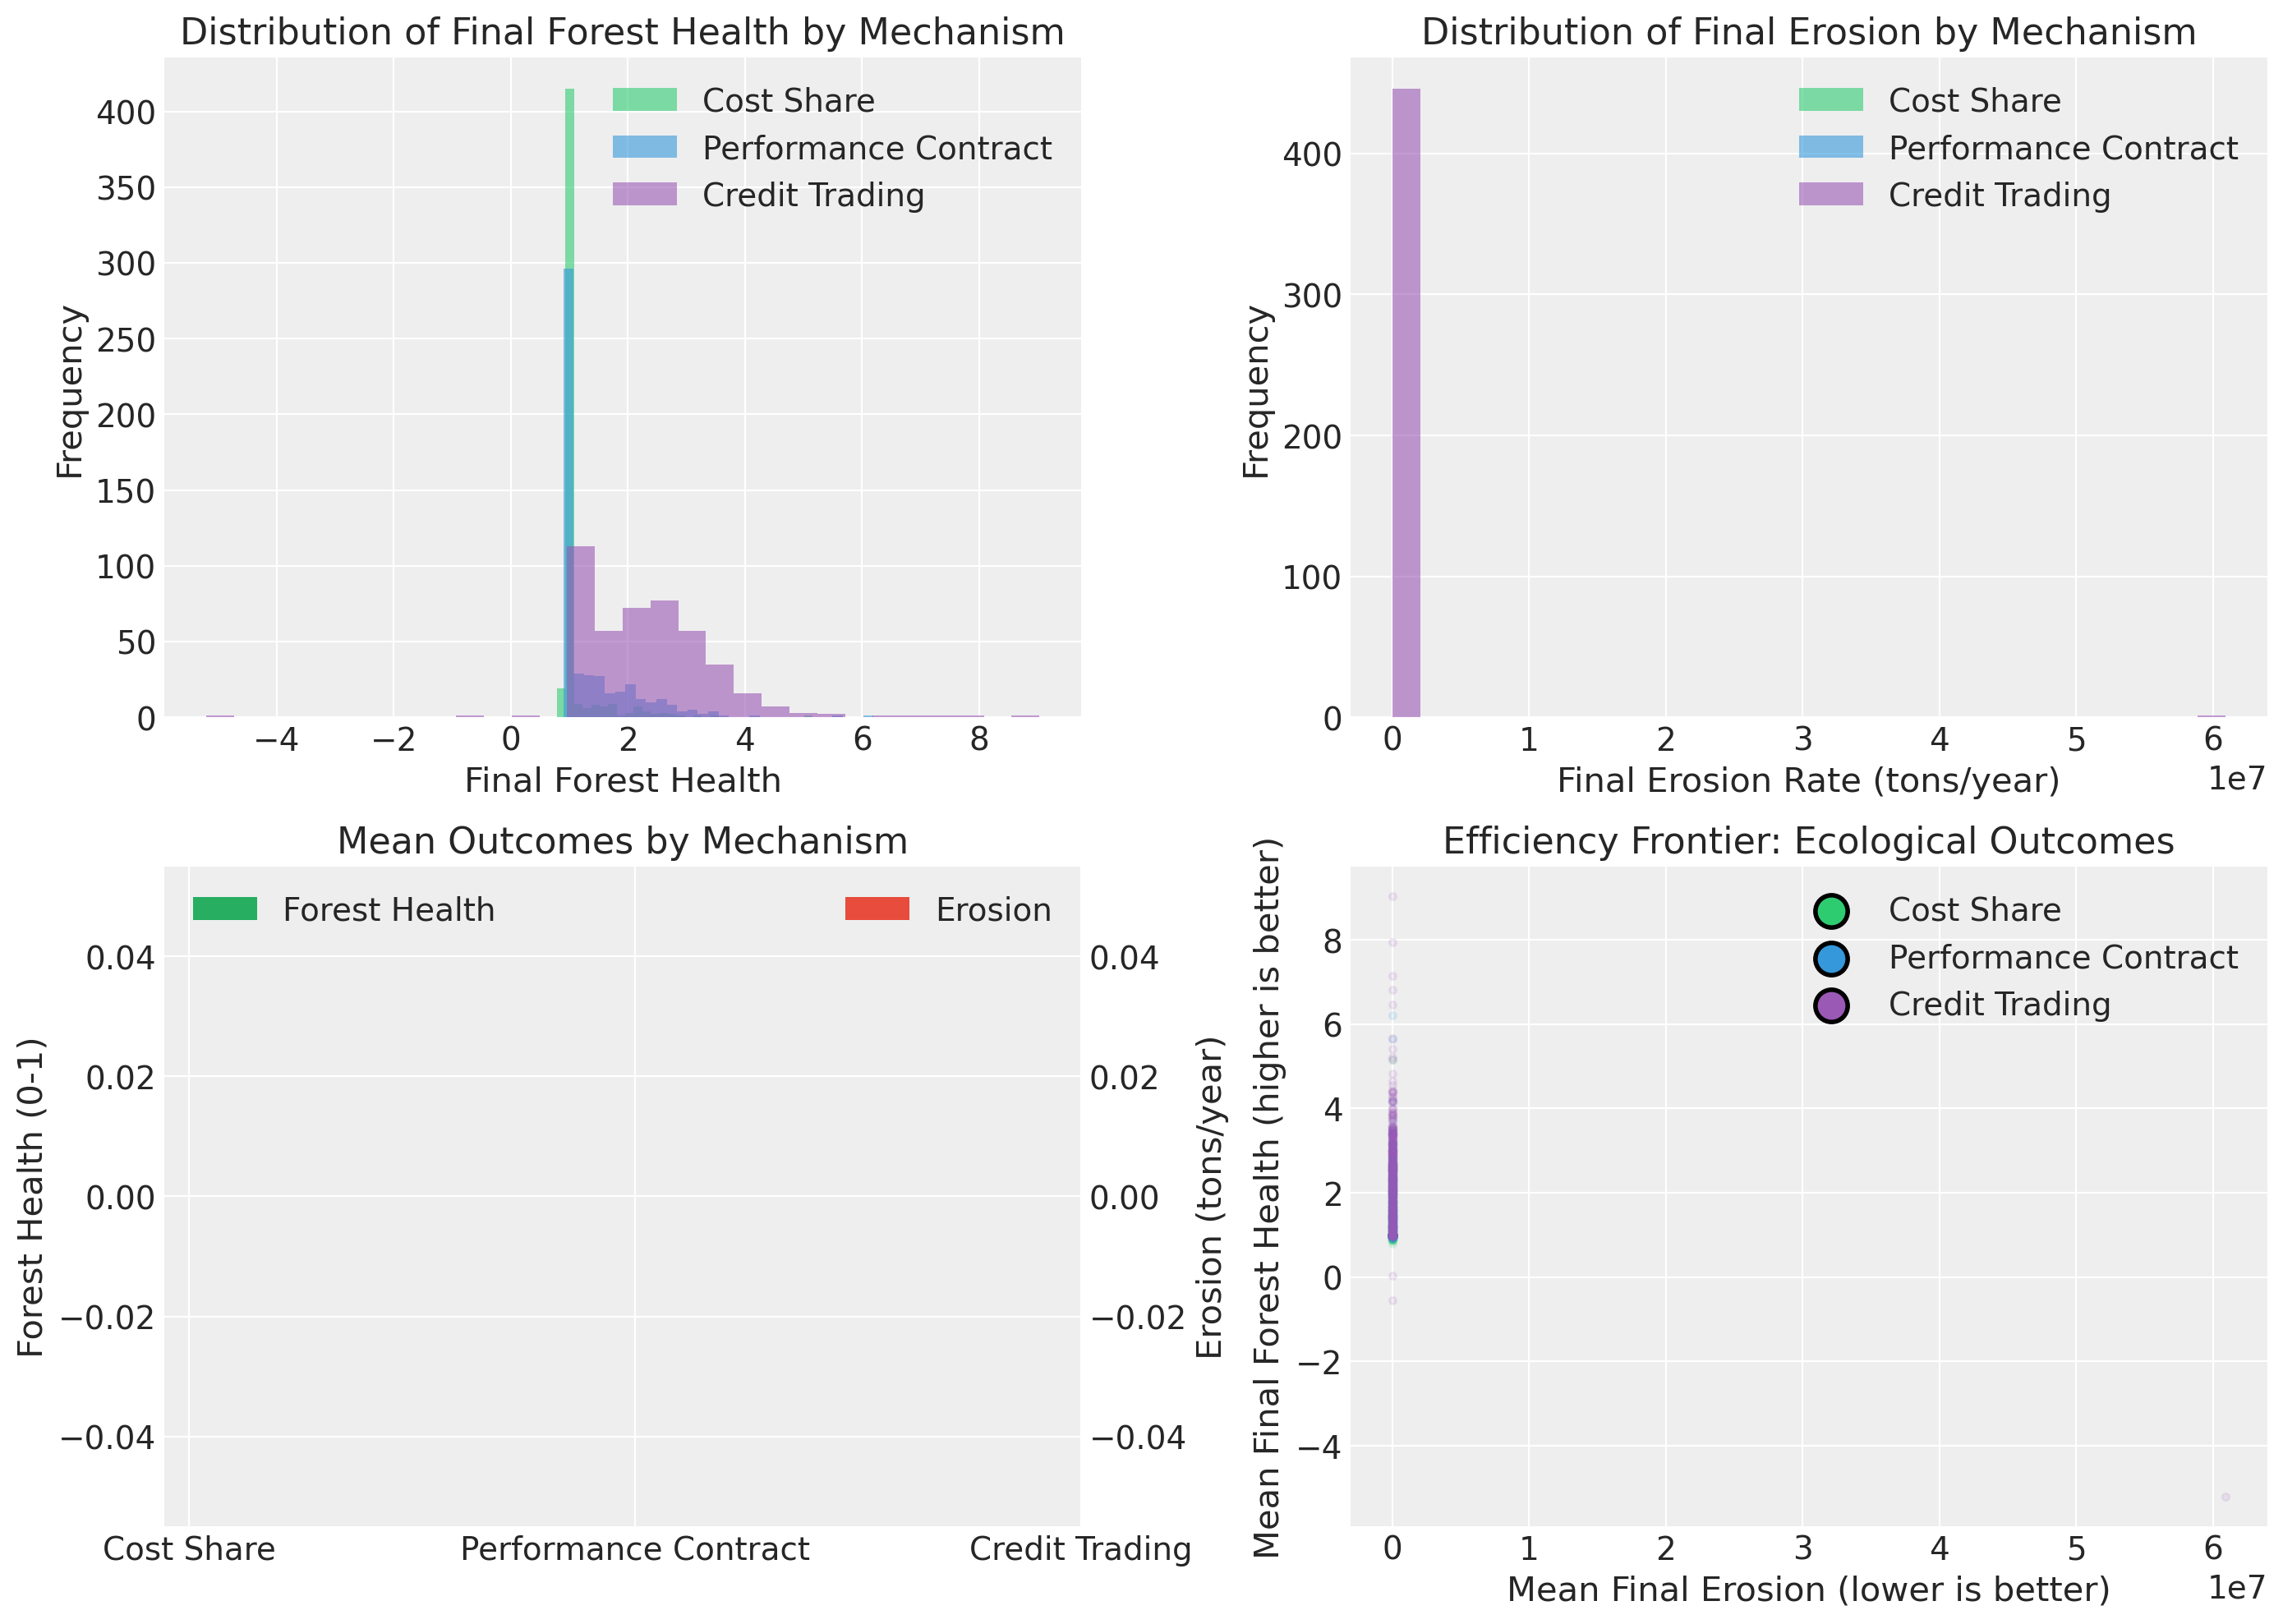

In [8]:
def plot_mechanism_comparison(results: dict, T: int):
    """
    Plot comparison of outcomes across mechanisms.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    colors = {
        "cost_share": "#2ecc71",
        "performance_contract": "#3498db",
        "credit_trading": "#9b59b6",
    }

    # Plot 1: Final forest health distribution
    ax = axes[0, 0]
    for mechanism, samples in results.items():
        ax.hist(
            samples["final_forest_health"],
            bins=30,
            alpha=0.6,
            label=mechanism.replace("_", " ").title(),
            color=colors[mechanism],
        )
    ax.set_xlabel("Final Forest Health")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of Final Forest Health by Mechanism")
    ax.legend()

    # Plot 2: Final erosion distribution
    ax = axes[0, 1]
    for mechanism, samples in results.items():
        ax.hist(
            samples["final_erosion"],
            bins=30,
            alpha=0.6,
            label=mechanism.replace("_", " ").title(),
            color=colors[mechanism],
        )
    ax.set_xlabel("Final Erosion Rate (tons/year)")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of Final Erosion by Mechanism")
    ax.legend()

    # Plot 3: Summary statistics
    ax = axes[1, 0]
    summary_data = []
    for mechanism, samples in results.items():
        summary_data.append(
            {
                "Mechanism": mechanism.replace("_", " ").title(),
                "Mean Forest Health": float(samples["final_forest_health"].mean()),
                "Mean Erosion": float(samples["final_erosion"].mean()),
            }
        )

    summary_df = pd.DataFrame(summary_data)
    x = np.arange(len(summary_df))
    width = 0.35

    bars1 = ax.bar(
        x - width / 2,
        summary_df["Mean Forest Health"],
        width,
        label="Forest Health",
        color="#27ae60",
    )
    ax2 = ax.twinx()
    bars2 = ax2.bar(
        x + width / 2,
        summary_df["Mean Erosion"],
        width,
        label="Erosion",
        color="#e74c3c",
    )

    ax.set_ylabel("Forest Health (0-1)")
    ax2.set_ylabel("Erosion (tons/year)")
    ax.set_xticks(x)
    ax.set_xticklabels(summary_df["Mechanism"])
    ax.set_title("Mean Outcomes by Mechanism")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

    # Plot 4: Efficiency frontier
    ax = axes[1, 1]
    for mechanism, samples in results.items():
        ax.scatter(
            samples["final_erosion"].mean(),
            samples["final_forest_health"].mean(),
            s=200,
            label=mechanism.replace("_", " ").title(),
            color=colors[mechanism],
            edgecolors="black",
            linewidths=2,
        )
        # Add uncertainty cloud
        ax.scatter(
            samples["final_erosion"],
            samples["final_forest_health"],
            alpha=0.1,
            color=colors[mechanism],
            s=10,
        )
    ax.set_xlabel("Mean Final Erosion (lower is better)")
    ax.set_ylabel("Mean Final Forest Health (higher is better)")
    ax.set_title("Efficiency Frontier: Ecological Outcomes")
    ax.legend()

    plt.tight_layout()
    return fig


fig = plot_mechanism_comparison(results, T)
plt.show()

## Counterfactual Analysis with `do` Operator

Using NumPyro's `do` operator, we can evaluate counterfactual scenarios: "What would happen if we intervened to set a specific mechanism?"


In [9]:
def counterfactual_analysis(
    base_mechanism: MechanismType,
    intervention_mechanism: MechanismType,
    rng_key: random.PRNGKey,
    num_samples: int = 500,
    T: int = 20,
) -> dict:
    """
    Compare factual and counterfactual outcomes.

    "If we were using base_mechanism, what would have happened
    if we had instead used intervention_mechanism?"
    """
    # Factual: what actually happened
    key1, key2 = random.split(rng_key)

    factual = simulate_mechanism(base_mechanism, key1, num_samples, T)
    counterfactual = simulate_mechanism(intervention_mechanism, key2, num_samples, T)

    # Calculate treatment effect
    ate_forest = (
        counterfactual["final_forest_health"].mean()
        - factual["final_forest_health"].mean()
    )
    ate_erosion = (
        counterfactual["final_erosion"].mean() - factual["final_erosion"].mean()
    )

    return {
        "factual": factual,
        "counterfactual": counterfactual,
        "ate_forest": ate_forest,
        "ate_erosion": ate_erosion,
    }


# Example: What if we switched from cost-sharing to performance contracts?
rng_key, subkey = random.split(rng_key)
cf_analysis = counterfactual_analysis(
    base_mechanism=MechanismType.COST_SHARE,
    intervention_mechanism=MechanismType.PERFORMANCE_CONTRACT,
    rng_key=subkey,
)

print("Counterfactual Analysis: Cost-Sharing -> Performance Contract")
print(f"Average Treatment Effect on Forest Health: {cf_analysis['ate_forest']:.4f}")
print(f"Average Treatment Effect on Erosion: {cf_analysis['ate_erosion']:.4f}")

Counterfactual Analysis: Cost-Sharing -> Performance Contract
Average Treatment Effect on Forest Health: 0.2766
Average Treatment Effect on Erosion: -0.1145


### Visualizing the Counterfactual Analysis

The plots below help us understand the causal effect of switching from one mechanism to another. These visualizations answer: **"What would happen if we changed our policy?"**


/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_3641/1803869204.py:205: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


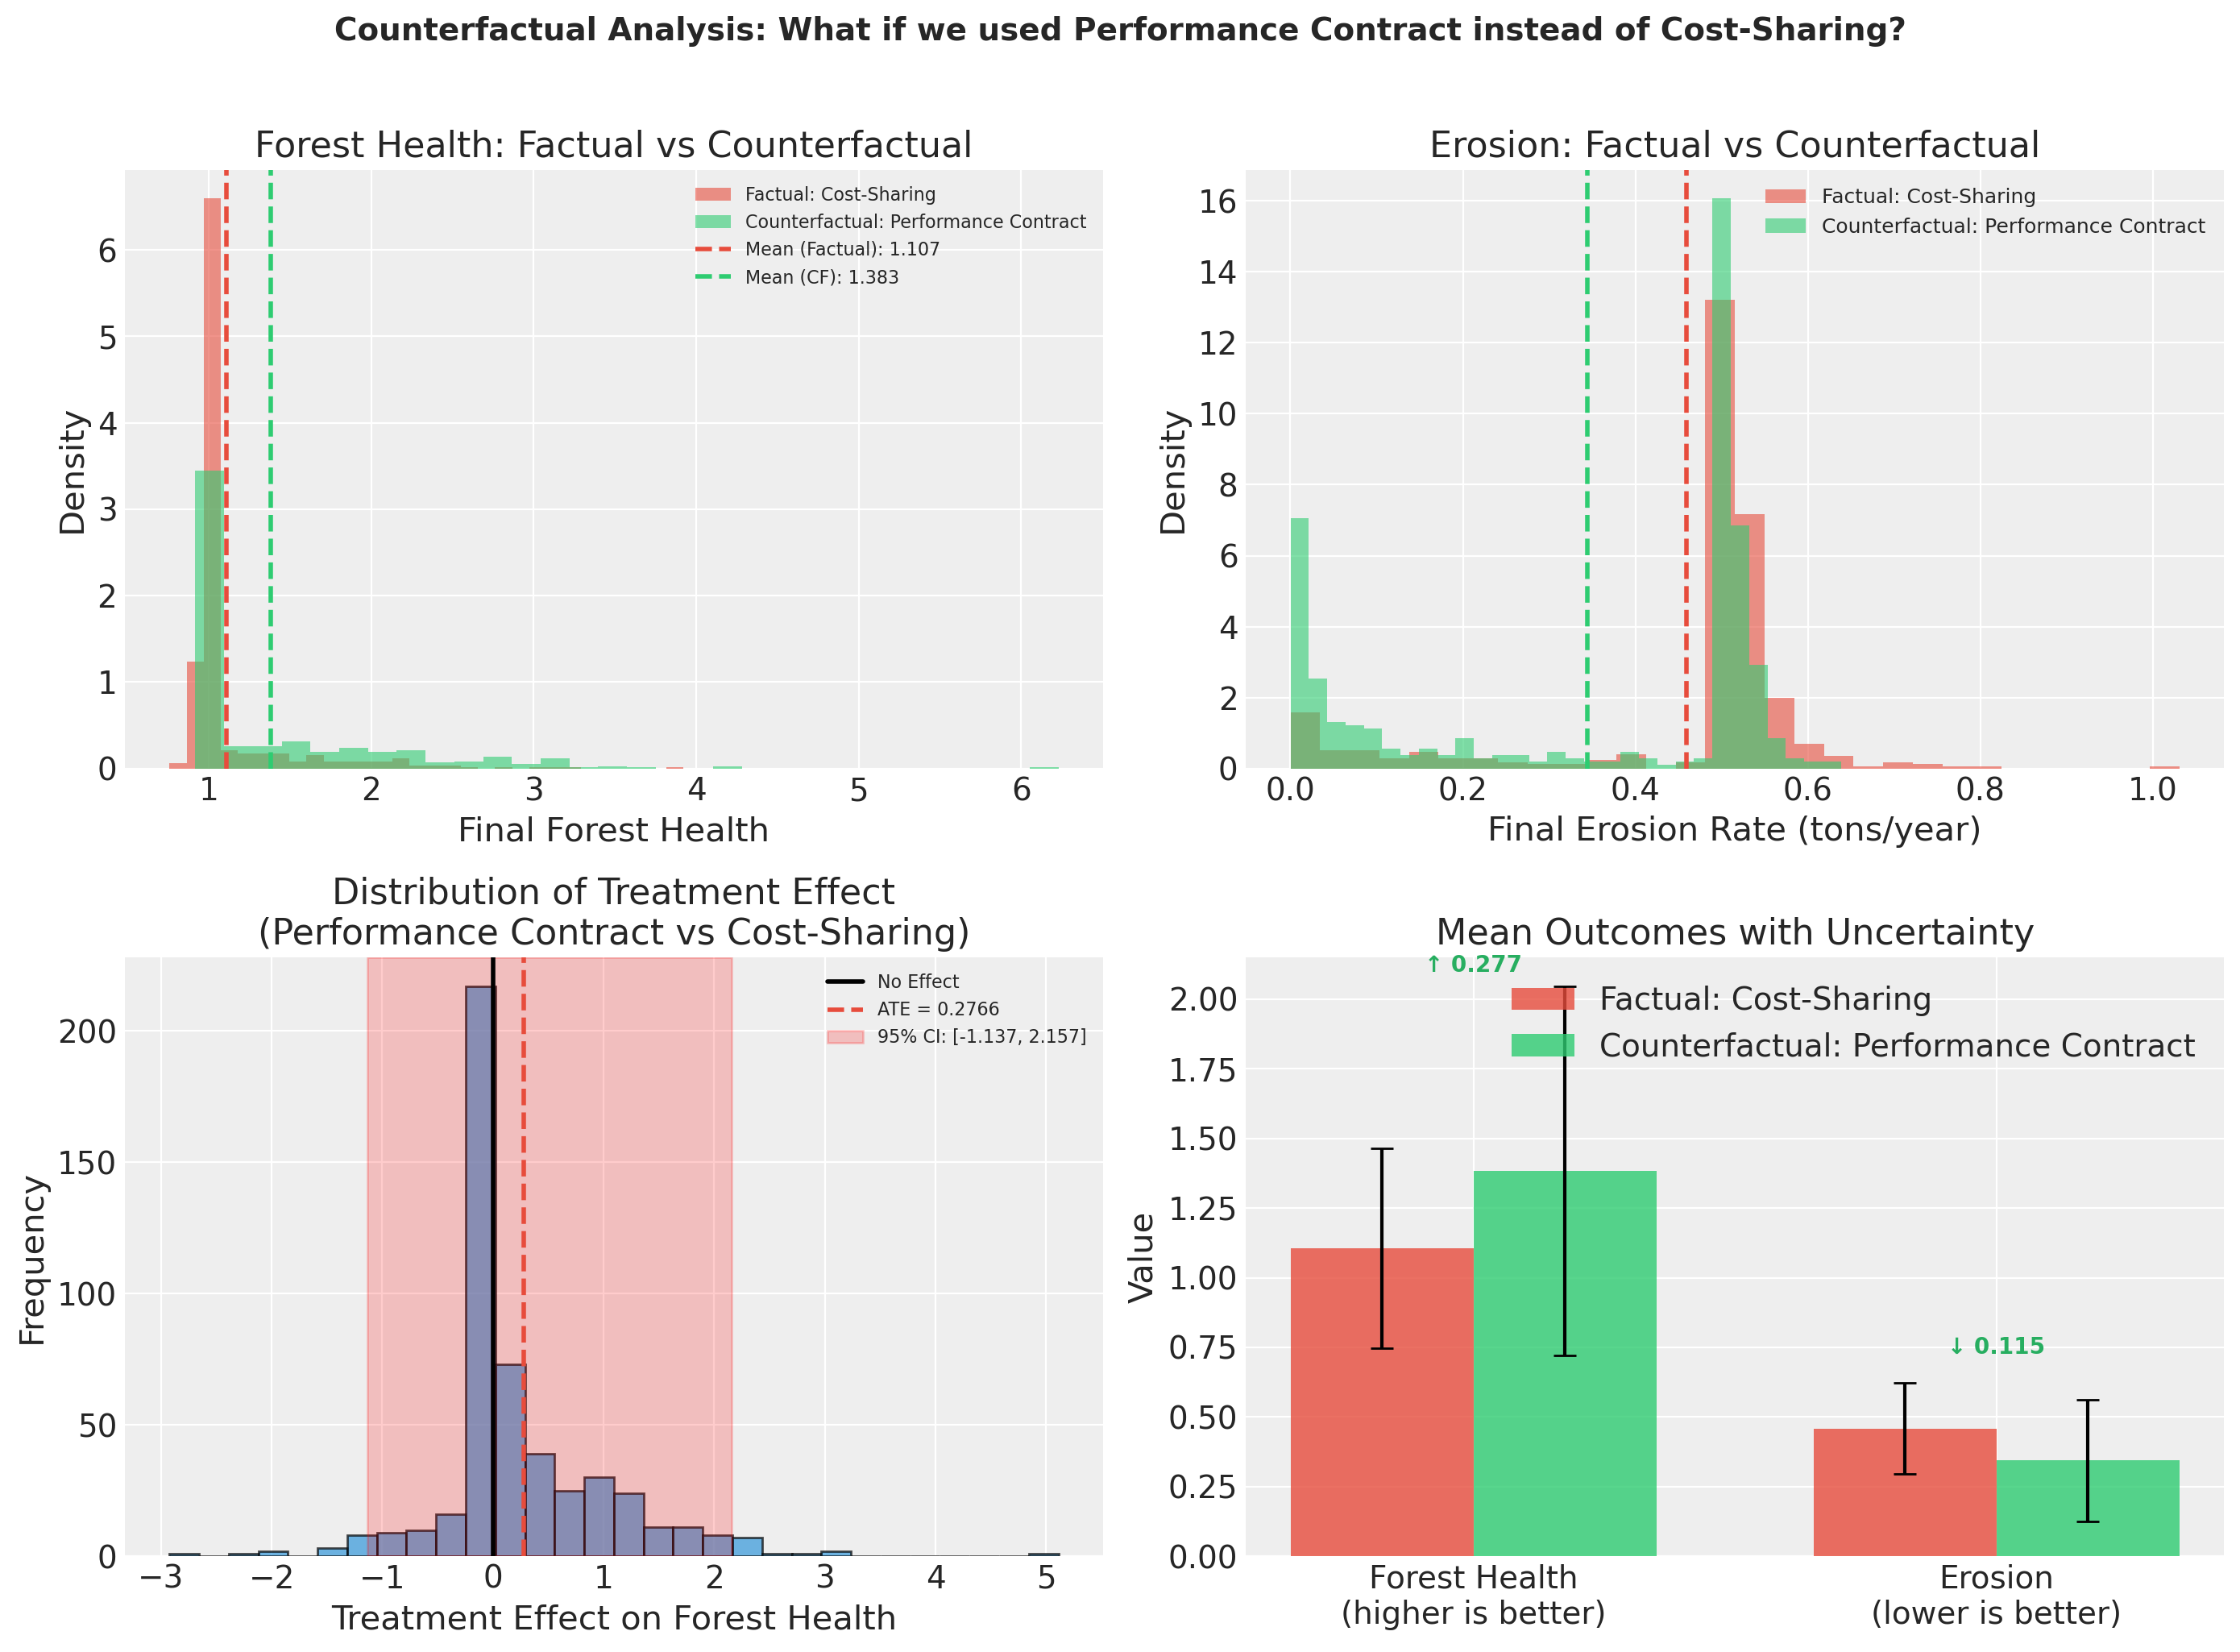

In [10]:
def plot_counterfactual_analysis(
    cf_analysis: dict, base_name: str, intervention_name: str
):
    """
    Visualize counterfactual analysis results.

    Creates a comprehensive visualization comparing factual vs counterfactual outcomes.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    factual = cf_analysis["factual"]
    counterfactual = cf_analysis["counterfactual"]
    ate_forest = cf_analysis["ate_forest"]
    ate_erosion = cf_analysis["ate_erosion"]

    colors = {"factual": "#e74c3c", "counterfactual": "#2ecc71"}

    # Plot 1: Forest Health - Overlapping Distributions
    ax = axes[0, 0]
    ax.hist(
        factual["final_forest_health"],
        bins=30,
        alpha=0.6,
        label=f"Factual: {base_name}",
        color=colors["factual"],
        density=True,
    )
    ax.hist(
        counterfactual["final_forest_health"],
        bins=30,
        alpha=0.6,
        label=f"Counterfactual: {intervention_name}",
        color=colors["counterfactual"],
        density=True,
    )
    ax.axvline(
        factual["final_forest_health"].mean(),
        color=colors["factual"],
        linestyle="--",
        linewidth=2,
        label=f"Mean (Factual): {factual['final_forest_health'].mean():.3f}",
    )
    ax.axvline(
        counterfactual["final_forest_health"].mean(),
        color=colors["counterfactual"],
        linestyle="--",
        linewidth=2,
        label=f"Mean (CF): {counterfactual['final_forest_health'].mean():.3f}",
    )
    ax.set_xlabel("Final Forest Health")
    ax.set_ylabel("Density")
    ax.set_title("Forest Health: Factual vs Counterfactual")
    ax.legend(fontsize=8)

    # Plot 2: Erosion - Overlapping Distributions
    ax = axes[0, 1]
    ax.hist(
        factual["final_erosion"],
        bins=30,
        alpha=0.6,
        label=f"Factual: {base_name}",
        color=colors["factual"],
        density=True,
    )
    ax.hist(
        counterfactual["final_erosion"],
        bins=30,
        alpha=0.6,
        label=f"Counterfactual: {intervention_name}",
        color=colors["counterfactual"],
        density=True,
    )
    ax.axvline(
        factual["final_erosion"].mean(),
        color=colors["factual"],
        linestyle="--",
        linewidth=2,
    )
    ax.axvline(
        counterfactual["final_erosion"].mean(),
        color=colors["counterfactual"],
        linestyle="--",
        linewidth=2,
    )
    ax.set_xlabel("Final Erosion Rate (tons/year)")
    ax.set_ylabel("Density")
    ax.set_title("Erosion: Factual vs Counterfactual")
    ax.legend(fontsize=9)

    # Plot 3: Treatment Effect Distribution (using bootstrap-style differences)
    ax = axes[1, 0]

    # Calculate pairwise differences (treatment effect for each simulation pair)
    n_samples = min(
        len(factual["final_forest_health"]), len(counterfactual["final_forest_health"])
    )
    forest_diff = (
        counterfactual["final_forest_health"][:n_samples]
        - factual["final_forest_health"][:n_samples]
    )
    erosion_diff = (
        counterfactual["final_erosion"][:n_samples]
        - factual["final_erosion"][:n_samples]
    )

    ax.hist(forest_diff, bins=30, alpha=0.7, color="#3498db", edgecolor="black")
    ax.axvline(0, color="black", linestyle="-", linewidth=2, label="No Effect")
    ax.axvline(
        ate_forest,
        color="#e74c3c",
        linestyle="--",
        linewidth=2,
        label=f"ATE = {ate_forest:.4f}",
    )
    # Add confidence interval (95%)
    ci_lower = np.percentile(forest_diff, 2.5)
    ci_upper = np.percentile(forest_diff, 97.5)
    ax.axvspan(
        ci_lower,
        ci_upper,
        alpha=0.2,
        color="red",
        label=f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]",
    )
    ax.set_xlabel("Treatment Effect on Forest Health")
    ax.set_ylabel("Frequency")
    ax.set_title(
        f"Distribution of Treatment Effect\n({intervention_name} vs {base_name})"
    )
    ax.legend(fontsize=8)

    # Plot 4: Summary Bar Chart with Error Bars
    ax = axes[1, 1]

    metrics = ["Forest Health\n(higher is better)", "Erosion\n(lower is better)"]
    factual_means = [
        float(factual["final_forest_health"].mean()),
        float(factual["final_erosion"].mean()),
    ]
    cf_means = [
        float(counterfactual["final_forest_health"].mean()),
        float(counterfactual["final_erosion"].mean()),
    ]
    factual_stds = [
        float(factual["final_forest_health"].std()),
        float(factual["final_erosion"].std()),
    ]
    cf_stds = [
        float(counterfactual["final_forest_health"].std()),
        float(counterfactual["final_erosion"].std()),
    ]

    x = np.arange(len(metrics))
    width = 0.35

    bars1 = ax.bar(
        x - width / 2,
        factual_means,
        width,
        yerr=factual_stds,
        label=f"Factual: {base_name}",
        color=colors["factual"],
        capsize=5,
        alpha=0.8,
    )
    bars2 = ax.bar(
        x + width / 2,
        cf_means,
        width,
        yerr=cf_stds,
        label=f"Counterfactual: {intervention_name}",
        color=colors["counterfactual"],
        capsize=5,
        alpha=0.8,
    )

    ax.set_ylabel("Value")
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_title("Mean Outcomes with Uncertainty")
    ax.legend()

    # Add ATE annotations
    for i, (f_mean, cf_mean) in enumerate(zip(factual_means, cf_means)):
        diff = cf_mean - f_mean
        arrow_color = (
            "#27ae60" if (i == 0 and diff > 0) or (i == 1 and diff < 0) else "#e74c3c"
        )
        direction = "↑" if diff > 0 else "↓"
        ax.annotate(
            f"{direction} {abs(diff):.3f}",
            xy=(i, max(f_mean, cf_mean) + max(factual_stds[i], cf_stds[i]) + 0.05),
            ha="center",
            fontsize=10,
            fontweight="bold",
            color=arrow_color,
        )

    plt.suptitle(
        f"Counterfactual Analysis: What if we used {intervention_name} instead of {base_name}?",
        fontsize=14,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    return fig


# Generate the counterfactual visualization
fig_cf = plot_counterfactual_analysis(
    cf_analysis,
    base_name="Cost-Sharing",
    intervention_name="Performance Contract",
)
plt.show()

### Interpreting the Counterfactual Plots

---

#### Plot 1: Forest Health Comparison (Top Left)

**What it shows**: Overlapping distributions of forest health outcomes under the factual (cost-sharing) and counterfactual (performance contract) scenarios.

**How to read it**:
- **Red distribution**: What happens with cost-sharing
- **Green distribution**: What *would have happened* with performance contracts
- **Dashed lines**: Mean outcomes for each scenario

**Key insight**: If the green distribution is shifted right of the red, performance contracts would have produced better forest outcomes.

---

#### Plot 2: Erosion Comparison (Top Right)

**What it shows**: Same comparison for erosion rates.

**How to read it**:
- We want LOW erosion, so green distribution should be shifted LEFT of red
- Look for overlap: where distributions overlap, outcomes are similar regardless of mechanism

---

#### Plot 3: Treatment Effect Distribution (Bottom Left)

**What it shows**: The distribution of the *difference* in outcomes - this is the causal effect of switching mechanisms.

**How to read it**:
- **X-axis**: Treatment effect (counterfactual - factual)
- **Black vertical line at 0**: No effect line
- **Red dashed line**: Average Treatment Effect (ATE)
- **Shaded region**: 95% confidence interval

**Key insight**: 
- If the entire distribution is right of 0, the intervention *consistently* improves outcomes
- If it straddles 0, the effect is uncertain
- The CI tells us the range of plausible treatment effects

---

#### Plot 4: Summary with Uncertainty (Bottom Right)

**What it shows**: Bar chart comparing mean outcomes with error bars showing standard deviation.

**How to read it**:
- **Red bars**: Factual outcomes (cost-sharing)
- **Green bars**: Counterfactual outcomes (performance contracts)
- **Error bars**: ±1 standard deviation (uncertainty)
- **Arrows**: Direction and magnitude of change

**Key insight**: Green arrows pointing up for forest health and down for erosion indicate improvement. Overlapping error bars suggest the difference may not be statistically significant.


### Additional Counterfactual: What if we used Credit Trading?

Let's also explore what would happen if we switched from cost-sharing to carbon credit trading:


Counterfactual Analysis: Cost-Sharing -> Credit Trading
Average Treatment Effect on Forest Health: nan
Average Treatment Effect on Erosion: nan


/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_3641/1803869204.py:205: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


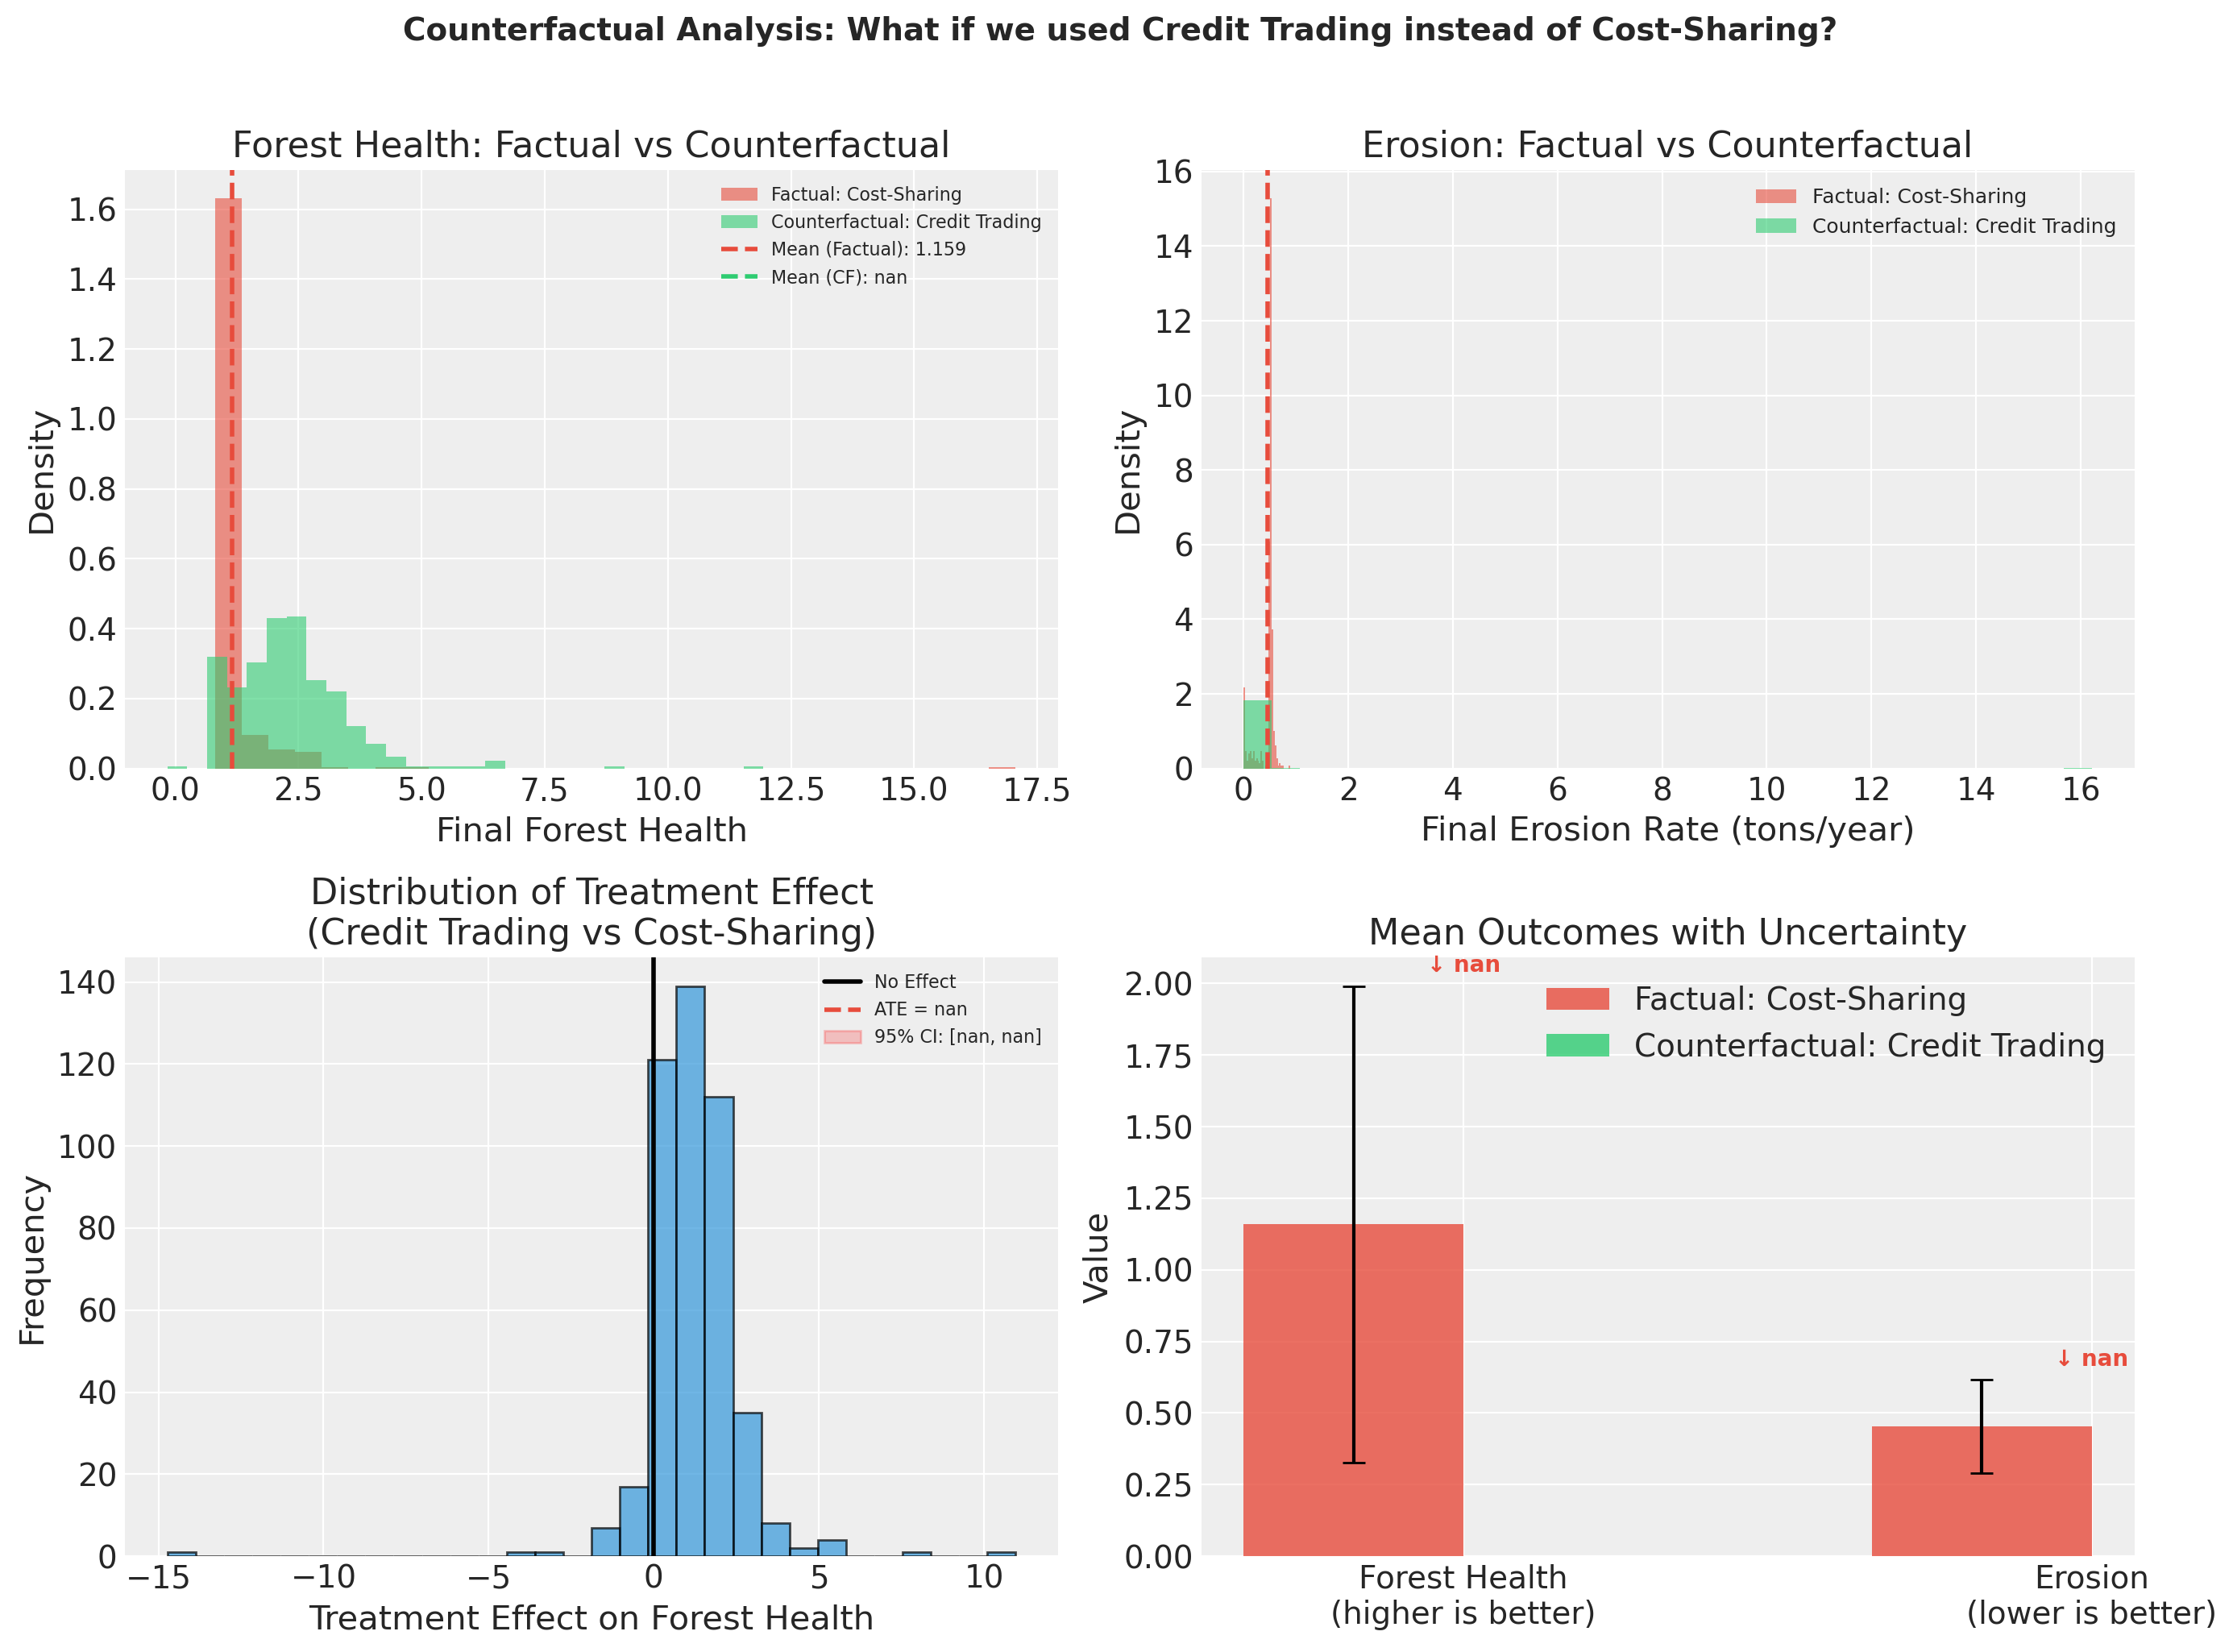

In [11]:
# Second counterfactual: Cost-sharing vs Credit Trading
rng_key, subkey = random.split(rng_key)
cf_analysis_credit = counterfactual_analysis(
    base_mechanism=MechanismType.COST_SHARE,
    intervention_mechanism=MechanismType.CREDIT_TRADING,
    rng_key=subkey,
)

print("Counterfactual Analysis: Cost-Sharing -> Credit Trading")
print(
    f"Average Treatment Effect on Forest Health: {cf_analysis_credit['ate_forest']:.4f}"
)
print(f"Average Treatment Effect on Erosion: {cf_analysis_credit['ate_erosion']:.4f}")

# Generate visualization
fig_cf_credit = plot_counterfactual_analysis(
    cf_analysis_credit,
    base_name="Cost-Sharing",
    intervention_name="Credit Trading",
)
plt.show()

### Summary: Comparing All Counterfactual Scenarios

Let's create a comprehensive summary comparing all mechanism switches:


/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_3641/1519127811.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


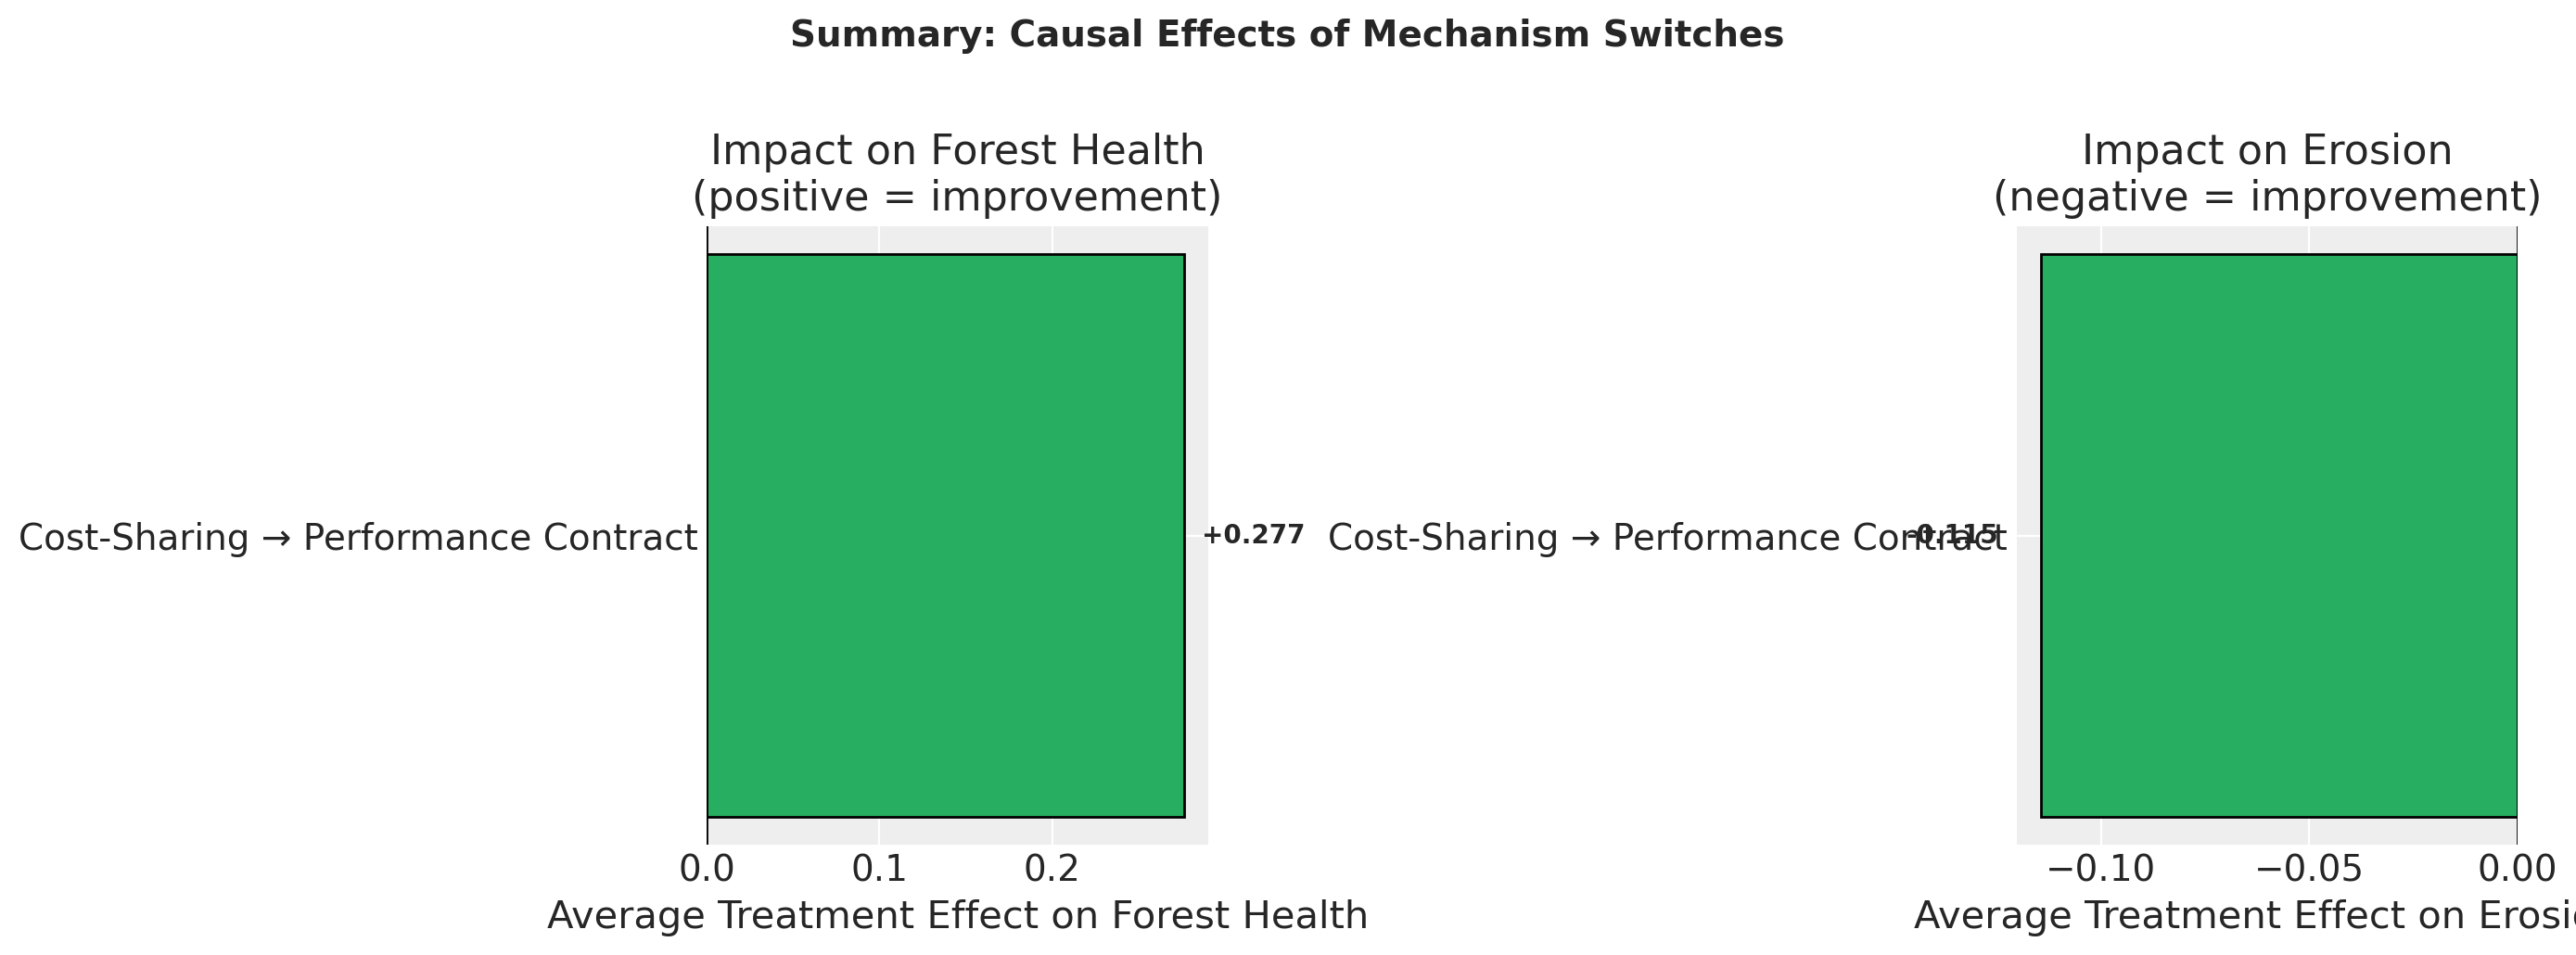


COUNTERFACTUAL ANALYSIS SUMMARY

Baseline: Cost-Sharing mechanism
----------------------------------------------------------------------
Intervention                        Forest Health Δ       Erosion Δ
----------------------------------------------------------------------
Performance Contract                        +0.2766         -0.1145
Credit Trading                                 +nan            +nan
----------------------------------------------------------------------

Interpretation:
  • Positive Forest Health Δ = Better ecological outcome
  • Negative Erosion Δ = Less sediment reaching dam (better)


In [12]:
# Create a comprehensive comparison of all counterfactual scenarios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prepare data for all comparisons
comparisons = [
    (
        "Cost-Sharing → Performance Contract",
        cf_analysis["ate_forest"],
        cf_analysis["ate_erosion"],
    ),
    (
        "Cost-Sharing → Credit Trading",
        cf_analysis_credit["ate_forest"],
        cf_analysis_credit["ate_erosion"],
    ),
]

labels = [c[0] for c in comparisons]
ate_forest_vals = [float(c[1]) for c in comparisons]
ate_erosion_vals = [float(c[2]) for c in comparisons]

# Plot 1: Treatment Effects on Forest Health
ax = axes[0]
colors_forest = ["#27ae60" if v > 0 else "#e74c3c" for v in ate_forest_vals]
bars = ax.barh(
    labels, ate_forest_vals, color=colors_forest, edgecolor="black", height=0.5
)
ax.axvline(0, color="black", linestyle="-", linewidth=1)
ax.set_xlabel("Average Treatment Effect on Forest Health")
ax.set_title("Impact on Forest Health\n(positive = improvement)")

# Add value labels
for bar, val in zip(bars, ate_forest_vals):
    ax.text(
        val + 0.01 if val > 0 else val - 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{val:+.3f}",
        ha="left" if val > 0 else "right",
        va="center",
        fontweight="bold",
    )

# Plot 2: Treatment Effects on Erosion
ax = axes[1]
colors_erosion = [
    "#27ae60" if v < 0 else "#e74c3c" for v in ate_erosion_vals
]  # Lower erosion is better
bars = ax.barh(
    labels, ate_erosion_vals, color=colors_erosion, edgecolor="black", height=0.5
)
ax.axvline(0, color="black", linestyle="-", linewidth=1)
ax.set_xlabel("Average Treatment Effect on Erosion")
ax.set_title("Impact on Erosion\n(negative = improvement)")

# Add value labels
for bar, val in zip(bars, ate_erosion_vals):
    ax.text(
        val + 0.01 if val > 0 else val - 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{val:+.3f}",
        ha="left" if val > 0 else "right",
        va="center",
        fontweight="bold",
    )

plt.suptitle(
    "Summary: Causal Effects of Mechanism Switches",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "=" * 70)
print("COUNTERFACTUAL ANALYSIS SUMMARY")
print("=" * 70)
print("\nBaseline: Cost-Sharing mechanism")
print("-" * 70)
print(f"{'Intervention':<35} {'Forest Health Δ':>15} {'Erosion Δ':>15}")
print("-" * 70)
print(
    f"{'Performance Contract':<35} {cf_analysis['ate_forest']:>+15.4f} {cf_analysis['ate_erosion']:>+15.4f}"
)
print(
    f"{'Credit Trading':<35} {cf_analysis_credit['ate_forest']:>+15.4f} {cf_analysis_credit['ate_erosion']:>+15.4f}"
)
print("-" * 70)
print("\nInterpretation:")
print("  • Positive Forest Health Δ = Better ecological outcome")
print("  • Negative Erosion Δ = Less sediment reaching dam (better)")
print("=" * 70)

## Fairness Analysis: Gini Coefficient

We measure distributional fairness using the Gini coefficient of agent utilities.


In [13]:
def gini_coefficient(utilities: jnp.ndarray) -> float:
    """
    Calculate Gini coefficient for utility distribution.

    Lower values indicate more equal distribution.
    """
    # Handle negative utilities by shifting
    shifted = utilities - utilities.min() + 1
    sorted_utils = jnp.sort(shifted)
    n = len(sorted_utils)
    cumulative = jnp.cumsum(sorted_utils)
    gini = (n + 1 - 2 * jnp.sum(cumulative) / cumulative[-1]) / n
    return float(gini)


# Example utilities for demonstration
example_utilities = jnp.array([1000.0, 500.0, 100.0, 800.0, 1200.0])
print(f"Example Gini coefficient: {gini_coefficient(example_utilities):.4f}")

Example Gini coefficient: 0.3478


## Summary and Next Steps

This prototype demonstrates:

1. **Ecological dynamics modeling** with stochastic forest growth and erosion
2. **Hierarchical agent decision model** with partial pooling
3. **Mechanism comparison** through simulation
4. **Counterfactual analysis** for policy evaluation
5. **Fairness metrics** for distributional outcomes

### Future Extensions

- Full MCMC inference for parameter estimation from real data
- More sophisticated agent utility functions
- Dynamic mechanism switching
- Integration with hypercerts for impact verification
- Interactive dashboard for scenario exploration
